In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Make sure you have the latest versions of PyKE and oktopus installed on your system:
- PyKE is a set of Python tools to analyse data from the Kepler satelitte
- SimpleKeplerPRF: PRF stands for Pixel Response Function, which describes how light from a point source (i.e. a star) is spread out on Kepler's detector based on the Point Spread Function (PSF) due to the telescope's optics *and* the jittering of the spacecraft during a normal exposure duration. This class creates a model based upon the known features of the Kepler PRF (it depends on which CCD channel the source is located on, as well as which row and column within that channel). Then, the model may be fit to data to find the flux of the source at different times and thus a lightcurve of that source.
- PRFPhotometry: Similar to SimpleKeplerPRF, PRF stands for Pixel Response Function. This class performs the Pixel Response Function (mentioned above) on TPF-like (in this case, TPF stands for Target Pixel File) files. In astronomy photometry is the technique of measuring the intensity (flux) of the electromagnetic radiation emitted from an astronomical object. The flux is then used to create a model of the respective PRF('s)
- SceneModel: SceneModel creates a model fitted to the tpf object created. After defining prior distributions of the SceneModel (including parameters of flux, center positions of the target(s), and constant background level) one can plot the fitted model. 
- KeplerTargetPixelFile is a class that handles target pixel files. The KeplerTargetPixelFile can also mask out cadences that are flagged by using the quality_bitmask argument used below.
- KeplerQualityFlags: encodes the meaning of the Kepler QUALITY bitmask flags as documented in Table 2-3 in the Kepler Archive Manual.
- oktopus is a set of Python tools to compute Bayesian statistics for different applications. In this case, we import UniformPrior from oktopus. UniformPrior is a class whose attributes are an n-number of upper and lower bounds (inputted as either single integers or arrays) and computes the negative-log pdf for the given n-dimensional independent uniform distribution.

In [2]:
from astropy.io import fits
import astropy

In [6]:
tpf = KeplerTargetPixelFile('./data/ktwo203551698-c02_lpd-targ.fits',
                            quality_bitmask=None)

In [7]:
from pyke import SimpleKeplerPRF, PRFPhotometry, SceneModel
from pyke import KeplerTargetPixelFile
from pyke.utils import KeplerQualityFlags
from oktopus import UniformPrior

### Check out a random frame of the above target pixel file to see how it looks:
You can change the frame number to inspect a few different snapshots of the source(s). Note that the two sources *do* move around on this subimage (jitter). 

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c1b33dfd0>)

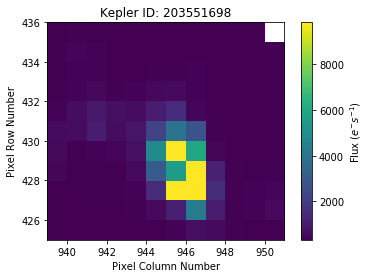

In [9]:
tpf.plot(frame=105,interpolation='nearest')

In [10]:
prf = SimpleKeplerPRF(channel=tpf.channel, shape=tpf.shape[1:], column=tpf.column, row=tpf.row)

### This target pixel file contains two blended stars, so we need to create a model with two PRFs:

In [11]:
scene = SceneModel(prfs=2*[prf])

### Looking at the TPF image above, we need to provide some lower (lb) and upper bounds (ub) on the star fluxes, positions, and background levels. Syntax is [flux1, column1, row1, flux2, column2, row2, background].

In [12]:
prior = UniformPrior(lb=[2e3, 942, 427, 2e3, 941, 429, 200],
                    ub=[2e5, 947, 431, 2e5, 947, 434, 2000])

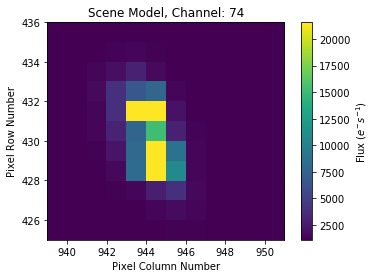

In [13]:
scene.plot(*prior.mean,interpolation='nearest')

In [14]:
phot = PRFPhotometry(scene_model=scene, prior=prior)

### Check to see if the background has been measured and subtracted from this target pixel file. We see it's all nan's, so it hasn't. (If it had been, we might add it back in at this point.)

In [15]:
tpf.flux_bkg

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

### Now run the psf photometry model fit. This can take a bit of time:

In [16]:
results = phot.fit(tpf.flux)

  0%|          | 0/3856 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
  0%|          | 11/3856 [00:00<02:56, 21.79it/s]/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
  1%|▏         | 50/3856 [00:02<02:52, 22.10it/s]/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1929: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
100%|██████████| 3856/3856 [03:32<00:00, 18.15it/s]


### Pull out the best fit fluxes, centroids, and background time series. Plot them.

In [17]:
flux_1 = results[:, 0]
xc_1 = results[:, 1]
yc_1 = results[:, 2]
flux_2 = results[:, 3]
xc_2 = results[:, 4]
yc_2 = results[:, 5]
bkg = results[:, -1]

(45000, 65000)

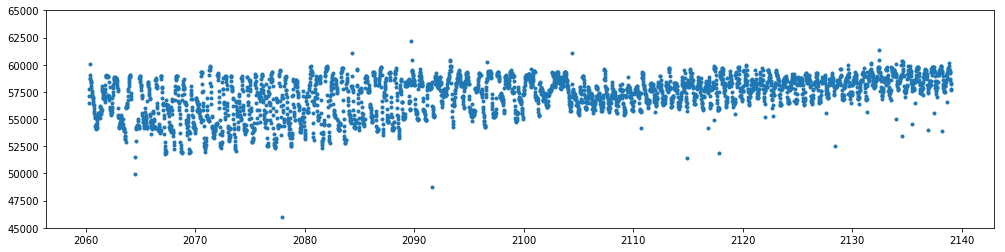

In [18]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, flux_1, 'o', markersize=3)
plt.ylim(45000,65000)

(25000, 40000)

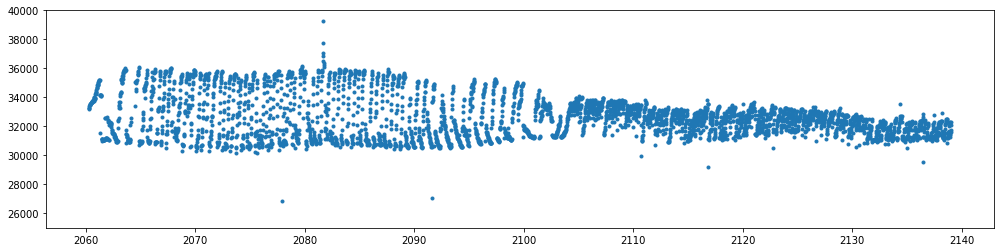

In [19]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, flux_2, 'o', markersize=3)
plt.ylim(25000,40000)

(944, 947)

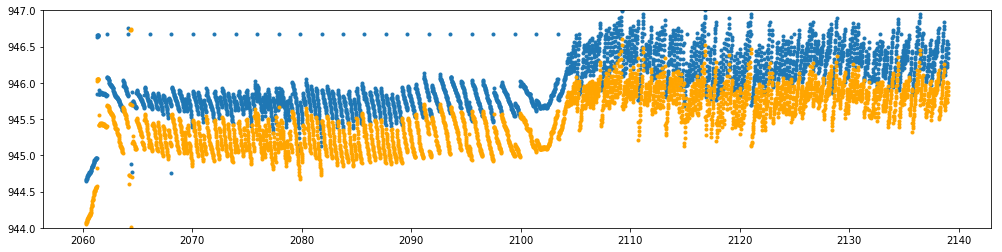

In [20]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, xc_1, 'o', markersize=3)
plt.plot(tpf.time, xc_2, 'o', color='orange',markersize=3)
plt.ylim(944,947)

(426.5, 430.5)

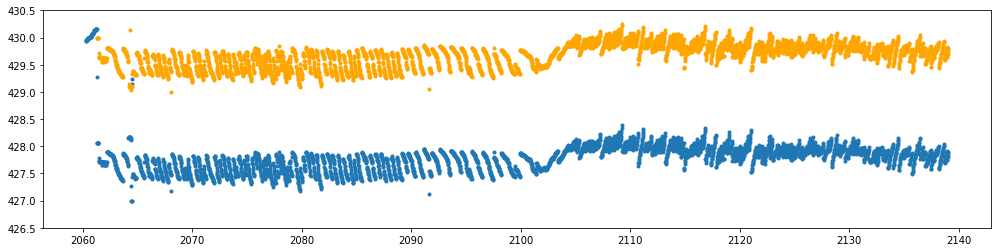

In [21]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, yc_1, 'o', markersize=3)
plt.plot(tpf.time, yc_2, 'o', color='orange',markersize=3)
plt.ylim(426.5,430.5)

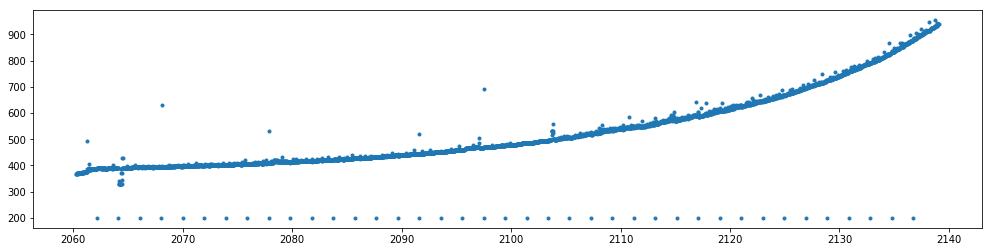

In [22]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, bkg, 'o', markersize=3)

### Write the data out to a file that is compatible with the k2sc detrending code. 

In [23]:
import astropy.io.ascii as ascii
from astropy.table import Table

In [24]:
newtable = {'Dates': tpf.time, 'Cadences': tpf.cadenceno, 'Flux1': flux_2, 'Uncert1': np.sqrt(flux_2), 'Xpos': xc_2, 'Ypos': yc_2, 'Quality': tpf.quality}
ascii.write(newtable, 'EPIC_203551698_psf.dat', names=['Dates','Cadences', 'Flux1','Uncert1', 'Xpos', 'Ypos', 'Quality'], formats={'Dates': '%.8f', 'Cadences': '%5i', 'Flux1': '%.8f', 'Uncert1': '%.8f', 'Xpos': '%.5f','Ypos': '%.5f', 'Quality': '%5i'})                                                                                                                                   

In [25]:
newtable = {'Dates': tpf.time, 'Cadences': tpf.cadenceno, 'Flux1': flux_1, 'Uncert1': np.sqrt(flux_1), 'Xpos': xc_1, 'Ypos': yc_1, 'Quality': tpf.quality}
ascii.write(newtable, 'EPIC_203551881_psf.dat', names=['Dates','Cadences', 'Flux1','Uncert1', 'Xpos', 'Ypos', 'Quality'], formats={'Dates': '%.8f', 'Cadences': '%5i', 'Flux1': '%.8f', 'Uncert1': '%.8f', 'Xpos': '%.5f','Ypos': '%.5f', 'Quality': '%5i'})                                                                                                                                   

### Run your favorite detrender here. SFF is usually sufficient, but not when the object has short-timescale variability like this one. We have run k2sc separately and input the results here.

In [26]:
tbl = Table.read('./data/EPIC_203551698_psf_detrend.fits')
dates = tbl['time']
quality = tbl['quality']
flux = tbl['flux_1']
trendt = tbl['trend_t_1']
mflags = tbl['mflags_1']
trendp = tbl['trend_p_1']
xpos = tbl['x']
ypos = tbl['y']

In [27]:
newfile = 'EPIC_203551698_psf_detrend.dat'
ascii.write(tbl,newfile)

In [28]:
tbl1 = Table.read('./data/EPIC_203551881_psf_detrend.fits')
dates = tbl1['time']
quality = tbl1['quality']
flux1 = tbl1['flux_1']
trendt1 = tbl1['trend_t_1']
mflags1 = tbl1['mflags_1']
trendp1 = tbl1['trend_p_1']
xpos = tbl1['x']
ypos = tbl1['y']

In [29]:
newfile1 = 'EPIC_203551881_psf_detrend.dat'
ascii.write(tbl1,newfile1)

### Compare with raw and aperture photometry results for this same object. You can see the effect of the detrending (before = cyan; after = red).

In [30]:
tbl2 = Table.read('./data/EPIC_203551881_xy_ap1.0_2.0_3.0_4.0_fixbox_detrend.fits')
dates2 = tbl2['time']
quality = tbl2['quality']
flux2 = tbl2['flux_2']
trendt2 = tbl2['trend_t_2']
mflags2 = tbl2['mflags_2']
trendp2 = tbl2['trend_p_2']
xpos = tbl2['x']
ypos = tbl2['y']

(50000, 62000)

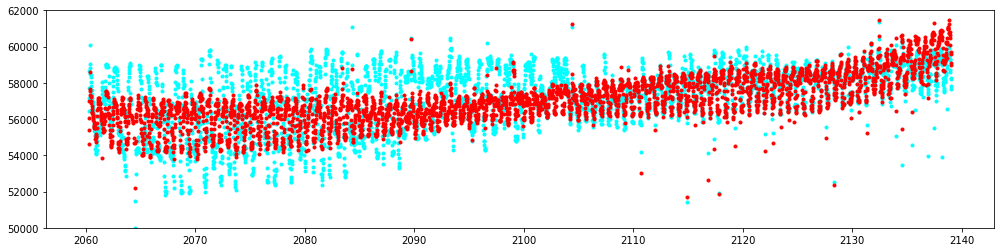

In [31]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, flux_1, 'o', color='cyan',markersize=3)
plt.plot(dates,flux1-trendp1+np.nanmedian(trendp1),'ro',markersize=3)
plt.ylim(50000,62000)

### Finally, compare psf photometry with aperture photometry. The former has much less of a long-term systematic. 

(50000, 80000)

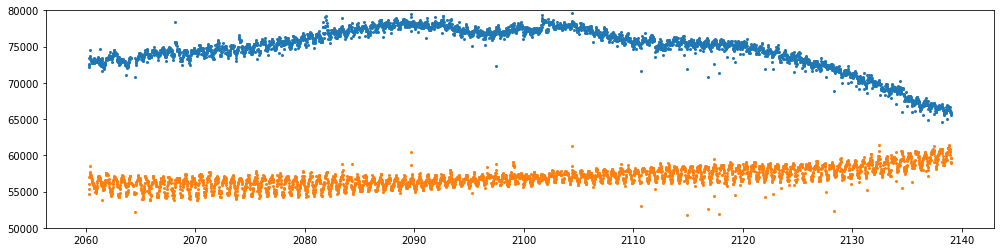

In [32]:
plt.figure(figsize=[17, 4])
plt.plot(dates2,flux2-trendp2+np.nanmedian(trendp2),'o',markersize=2)
plt.plot(dates, flux1-trendp1+np.nanmedian(trendp1), 'o', markersize=2)
plt.ylim(50000,80000)

(52000, 62000)

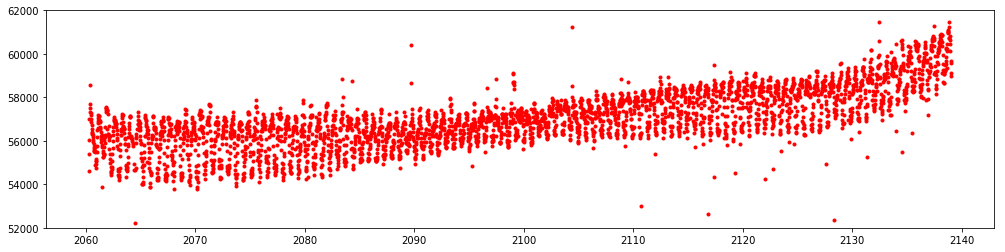

In [33]:
plt.figure(figsize=[17, 4])
plt.plot(dates,flux1-trendp1+np.nanmedian(trendp1),'ro',markersize=3)
plt.ylim(52000,62000)

### We can also check out the light curve of star #2 in the target pixel file. Looks like it has a longer timescale periodic variability.

(29000, 37000)

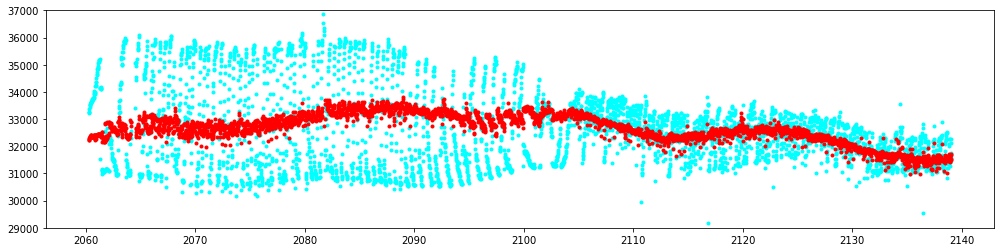

In [34]:
plt.figure(figsize=[17, 4])
good = np.where(mflags < 8)
plt.plot(tpf.time, flux_2, 'o', color='cyan',markersize=3)
plt.plot(dates[good],flux[good]-trendp[good]+np.nanmedian(trendp[good]),'ro',markersize=3)
plt.ylim(29000,37000)